In [87]:
from astropy.table import Table,Column
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties import unumpy as unp


## LOAD FILES

In [4]:
catalog_cosmos = '/Users/arpita/Documents/Master_thesis/catalogs/primer-cosmos_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat'


catalog_uds = '/Users/arpita/Documents/Master_thesis/catalogs/primer-uds_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat'


catalog_ceers = '/Users/arpita/Documents/Master_thesis/catalogs/ceers_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat'




## READ FILES

In [5]:
read_cosmos = Table.read(catalog_cosmos, format='ascii')
read_uds = Table.read(catalog_uds, format='ascii')
read_ceers = Table.read(catalog_ceers, format='ascii')

# SAMPLE SELECTION CRITERIA:

## PARENT SAMPLE :
### sn_f444w>=5 & flag_f150w =0 & flag_f444w =0 & junk_flag = 0
----------------
----------------

## OFGs :
### F150W>26.5mag; F150W-F444W>2mag &  
### sn_f444w>=5 & sn_f150w >= 3 & flag_f150w =0 & flag_f444w =0 & junk_flag = 0 

### If sn_f150w < 3, the 2sigma upper limit is used.
----------------
----------------
## LRDs :

### sn_f444w>14 & F444W < 27.7 & flag_fxxxw =0 & junk_flag = 0 & sn_fxxxw >= 3

### red1  & red2 criteria taken from Labbe+23b :
### red1 = (115 − 150 < 0.8) (200 − 277 > 0.7) (200 − 356 > 1.0) 
### red2 = (150 − 200 < 0.8) (277 − 356 > 0.7) (277 − 444 > 1.0)

----------------
----------------
----------------


## note that magnitude calculation  must be done to convert from nJy to Mag
### F150W = 23.9-2.5*np.log10(f_f150w/1000)
### 2sigma_F150W = 23.9-2.5*np.log10(2* e_f150w/1000) 

----------------
----------------
----------------






## Creating a function to create samples for each catalog based on input


In [85]:

def selection(catalog_name):
    catalog = Table.read(catalog_name, format='ascii')
    print("Catalog length: ",len(catalog))
#defining parent catalog 
    p = np.where((catalog['sn_f444w'] >= 5.0) 
             & (catalog['flag_f150w'] == 0) 
             & (catalog['flag_f444w'] == 0) 
             & (catalog['junk_flag'] == 0)
             & (np.isfinite(catalog['f_f444w'])==True)
             & (np.isfinite(catalog['f_f150w'])==True)
             & (np.isfinite(catalog['e_f444w'])==True)
             & (np.isfinite(catalog['e_f150w'])==True)
             & (catalog['f_f444w'] > 0.)
             & (catalog['e_f444w'] > 0.)
             & (catalog['f_f150w'] > 0.)
             & (catalog['e_f150w'] > 0.)
            )[0]

    Parent = catalog[p]
#     f_f444w_mag_data = 23.9 - (2.5 * (np.log10(Parent['f_f444w'] / 1000)))
#     f_f444w_mag = Column(f_f444w_mag_data, name='f_f444w_mag')
    
#     e_f444w_mag_data = 23.9 - (2.5 * np.log10(Parent['e_f444w'] / 1000))
#     e_f444w_mag = Column(e_f444w_mag_data, name='e_f444w_mag')
    
#     f_f150w_mag_data = 23.9 - (2.5 * (np.log10(Parent['f_f150w'] / 1000)))
#     f_f150w_mag = Column(f_f150w_mag_data, name='f_f150w_mag')
    
#     e_f150w_mag_data = 23.9 - (2.5 * np.log10(Parent['e_f150w'] / 1000))
#     e_f150w_mag = Column(e_f150w_mag_data, name='e_f150w_mag')
    
    
    
    f444w_mag_data = 23.9 - (2.5 * (unp.log10(unp.uarray(Parent['f_f444w'],abs(Parent['e_f444w'])) / 1000)))
    f_f444w_mag = Column(unp.nominal_values(f444w_mag_data), name='f_f444w_mag')
    e_f444w_mag = Column(unp.std_devs(f444w_mag_data), name='e_f444w_mag')
    
    f150w_mag_data = 23.9 - (2.5 * (unp.log10(unp.uarray(Parent['f_f150w'],abs(Parent['e_f150w'])) / 1000)))
    f_f150w_mag = Column(unp.nominal_values(f150w_mag_data), name='f_f150w_mag')
    e_f150w_mag = Column(unp.std_devs(f150w_mag_data), name='e_f150w_mag')
    
    

    Parent.add_columns([f_f444w_mag,e_f444w_mag,f_f150w_mag,e_f150w_mag])

    save_parent = f"{catalog_name}_parent"
    print("Parent sample length:",len(Parent))
    Parent.write(save_parent, format ='fits',overwrite = True)
    
    
    #############################################################################################################
    #############################################################################################################
#OFGs
    ofg_1 = np.where((23.9 - 2.5 * np.log10(Parent['f_f150w'] / 1000) > 26.5) & 
                  ((23.9 - 2.5 * np.log10(Parent['f_f150w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f444w'] / 1000))> 2) 
                  & (Parent['sn_f444w'] >= 5) & 
                  (Parent['sn_f150w'] >= 3) & 
                  (Parent['flag_f150w'] == 0) & 
                  (Parent['flag_f444w'] == 0) & 
                  (Parent['junk_flag'] == 0))[0]

    ofg_2 = np.where((23.9 - 2.5 * np.log10(Parent['f_f150w'] / 1000) > 26.5) & 
                  ((23.9 - 2.5 * np.log10(Parent['f_f150w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f444w'] / 1000))> 2) 
                  & (Parent['sn_f444w'] >= 5) & 
                  (Parent['flag_f150w'] == 0) & 
                  (Parent['flag_f444w'] == 0) & 
                  (Parent['junk_flag'] == 0) & 
                  (Parent['sn_f150w'] < 3))[0]

# note : for OFG_A  the actual magnitude is used as the sn ratio for F444W is greater than equal to 3
    OFG_A = Parent[ofg_1]
    print("OFG_A sample",len(OFG_A))
    save_OFG_A = f"{catalog_name}_OFG_A"
    OFG_A.write(save_OFG_A,format='fits',overwrite=True)
    
    
#############################################################################################################    
    
# note : for OFG_B  the 2Sigma upper limit is used as the sn ratio for F444W is less than 3
    OFG_B = Parent[ofg_2]
    print("OFG_B sample: ",len(OFG_B))
    save_OFG_B = f"{catalog_name}_OFG_B"
    OFG_B.write(save_OFG_B,format='fits',overwrite=True)
        
    
    #############################################################################################################
    #############################################################################################################
#LRDs

    lrd_common = (Parent['sn_f444w'] > 14) & (23.9 - 2.5 * np.log10(Parent['f_f444w'] / 1000) < 27.7) & (Parent['junk_flag'] == 0) & (Parent['flag_f115w'] == 0) & (Parent['flag_f150w'] == 0) & (Parent['flag_f200w'] == 0) & (Parent['flag_f277w'] == 0) & (Parent['flag_f356w'] == 0) & (Parent['flag_f444w'] == 0) &(Parent['sn_f115w'] >=2) &(Parent['sn_f150w'] >=2)&(Parent['sn_f200w'] >=2)&(Parent['sn_f277w'] >=2)&(Parent['sn_f356w'] >=2)

#First LRD criteria :
    
    lrd_1= ((23.9 - 2.5 * np.log10(Parent['f_f115w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f150w'] / 1000)) < 0.8) & ((23.9 - 2.5 * np.log10(Parent['f_f200w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f277w'] / 1000)) > 0.7) & ((23.9 - 2.5 * np.log10(Parent['f_f200w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f356w'] / 1000)) > 1.0)
    red_1 = np.where(lrd_common & lrd_1)[0]

    LRD_1 = Parent[red_1]
    print("RED_1 sample: ",len(LRD_1))
    save_RED_1 = f"{catalog_name}_red_1"
    LRD_1.write(save_RED_1,format='fits',overwrite=True)
    
#Second LRD criteria :

    lrd_2 = ((23.9 - 2.5 * np.log10(Parent['f_f150w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f200w'] / 1000)) < 0.8) & ((23.9 - 2.5 * np.log10(Parent['f_f277w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f356w'] / 1000)) > 0.7) & ((23.9 - 2.5 * np.log10(Parent['f_f277w'] / 1000)) - (23.9 - 2.5 * np.log10(Parent['f_f444w'] / 1000)) > 1.0)
    red_2 = np.where(lrd_common & lrd_2)[0]

    LRD_2 = Parent[red_2]
    print("RED_2 sample: ",len(LRD_2))
    save_RED_2 = f"{catalog_name}_red_2"
    LRD_2.write(save_RED_2,format='fits',overwrite=True)



#############################################################################################################
#############################################################################################################
    
#Plotting 
    plt.figure(figsize=(25, 20))

# Plot Parent and OFG_A with dots

    
    plt.scatter(Parent['f_f444w_mag'],Parent['f_f150w_mag']-Parent['f_f444w_mag'], marker='o',facecolors='none', edgecolors='orange',label='Parent')

    plt.scatter(OFG_A['f_f444w_mag'],OFG_A['f_f150w_mag']-OFG_A['f_f444w_mag'], marker='o', color='deeppink', label='OFGs with sn_f150w >=3')
    
# Plot OFG_B with arrows
    col = -2.5 * np.log10((OFG_B['e_f150w']*2.) / OFG_B['f_f444w'])
    
#     plt.quiver(OFG_B['f_f444w_mag'], (OFG_B['f_f150w_mag']-OFG_B['f_f444w_mag']),0,3, color='teal', label='OFGs with sn_f150w <3', angles='xy', scale_units='x', scale=9)
    plt.quiver(OFG_B['f_f444w_mag'], col, 0,3, color='teal', label='OFGs with sn_f150w <3', angles='xy', scale_units='x', scale=9)
#     plt.hlines(2,24.7,30)
    
    plt.xlabel('F444W', fontstyle='italic',fontsize=50)
    plt.ylabel('F150W-F444W',fontstyle='italic',fontsize=50)
    plt.legend(fontsize=30,loc='upper left')
    plt.title('SAMPLE',fontstyle='italic',fontsize=70)
    plt.grid(True)
    plt.ylim(-2.,7.)
    plt.show()
    return save_parent ,save_OFG_A,save_OFG_B,save_RED_1,save_RED_2

# PRIMER-COSMOS

Catalog length:  10873
Parent sample length: 7420
OFG_A sample 47
OFG_B sample:  165
RED_1 sample:  58
RED_2 sample:  25


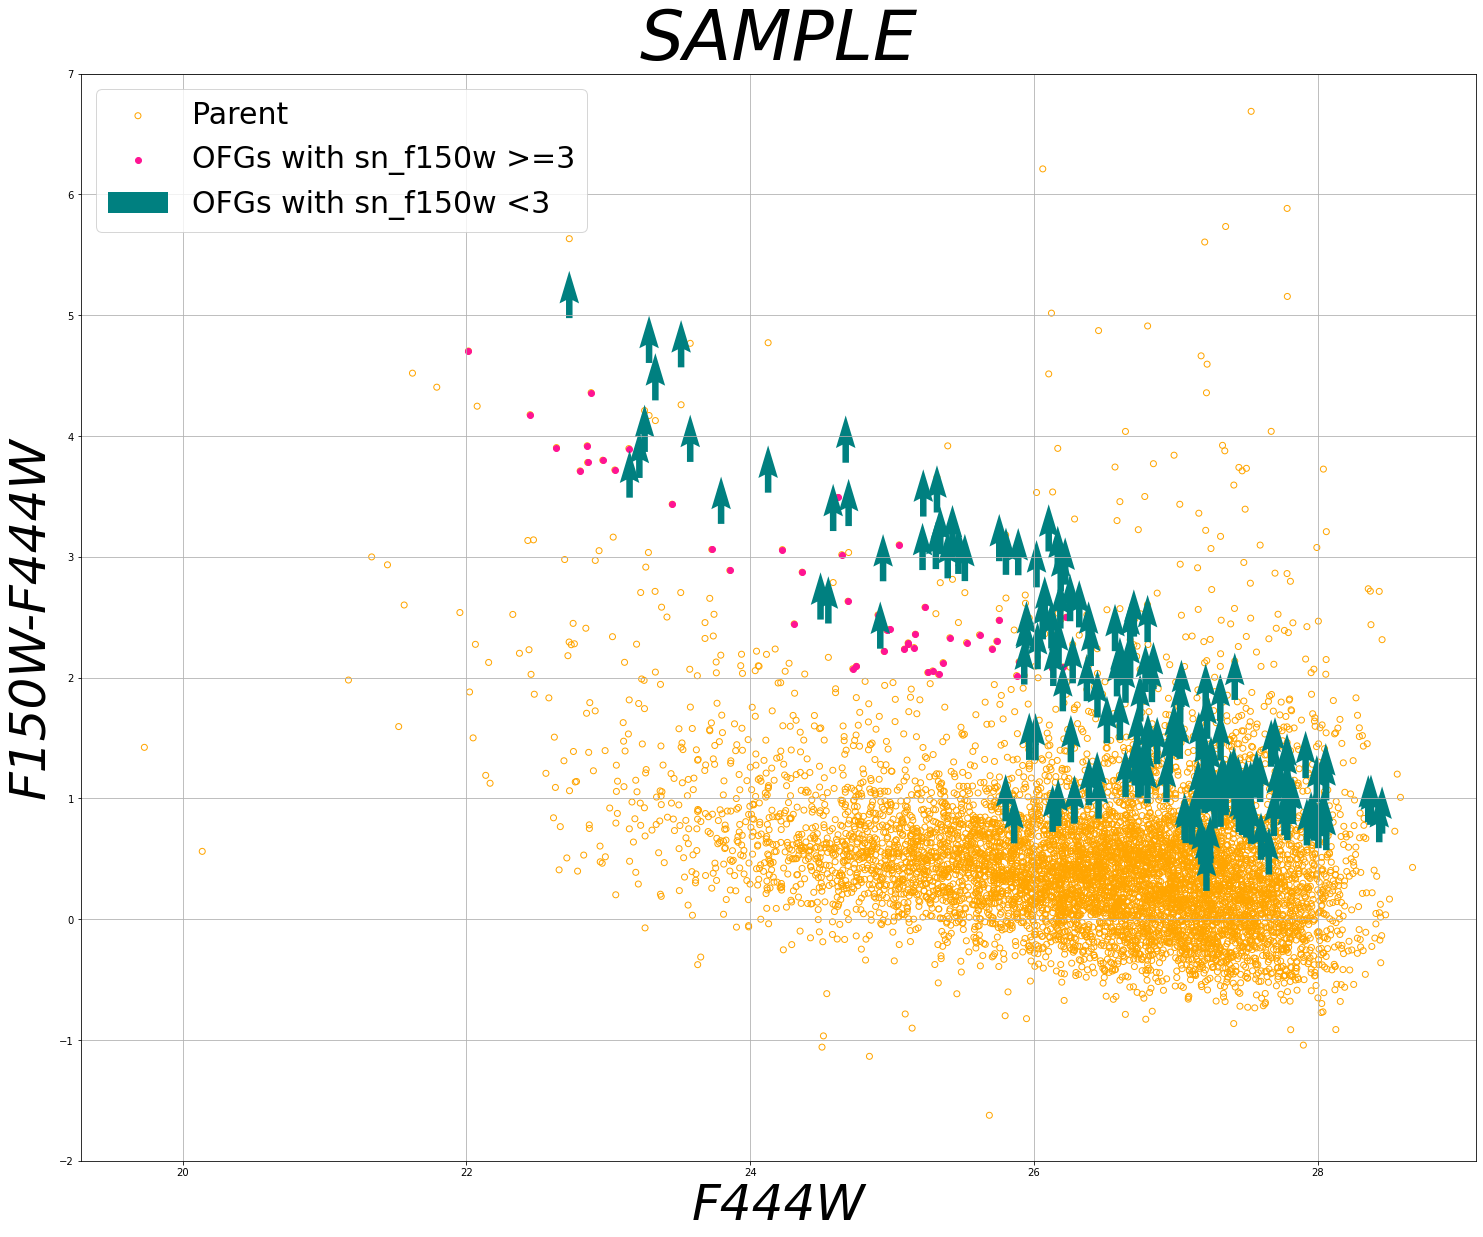

('/Users/arpita/Documents/Master_thesis/catalogs/primer-cosmos_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat_parent',
 '/Users/arpita/Documents/Master_thesis/catalogs/primer-cosmos_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat_OFG_A',
 '/Users/arpita/Documents/Master_thesis/catalogs/primer-cosmos_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat_OFG_B',
 '/Users/arpita/Documents/Master_thesis/catalogs/primer-cosmos_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat_red_1',
 '/Users/arpita/Documents/Master_thesis/catalogs/primer-cosmos_imgv7.0_photcatv0_lw_det_bagpipescat_aper8_zphot_selzgt3_cleaned.cat_red_2')

In [86]:
selection(catalog_cosmos)


28.9 because the value of each pixel is in 10nJy